##  Dataset Overview

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import kagglehub
dataset_path = kagglehub.dataset_download("rohitsuresh15/radroad-anomaly-detection")
print(f"Dataset: {dataset_path}\n")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}\n")

base = Path(dataset_path) / 'images'
splits = {
    'train': (base/'train'/'images', base/'train'/'labels'),
    'test': (base/'test'/'images', base/'test'/'labels'),
    'valid': (base/'valid'/'images', base/'valid'/'labels')
}

class_names = ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']
DAMAGE_CLASS = 3

print("Data splits:")
for name, (imgs, lbls) in splits.items():
    print(f"   {name:5s}: {len(list(imgs.glob('*.jpg'))):4d} images")
print()

Using Colab cache for faster access to the 'radroad-anomaly-detection' dataset.
Dataset: /kaggle/input/radroad-anomaly-detection

Device: cuda

Data splits:
   train: 5843 images
   test : 1263 images
   valid: 1288 images



In [2]:
def read_boxes(lbl_path):
    if not lbl_path.exists():
        return []
    boxes = []
    for line in open(lbl_path):
        p = line.strip().split()
        if len(p) >= 5:
            boxes.append({
                'class_id': int(p[0]),
                'x': float(p[1]),
                'y': float(p[2]),
                'w': float(p[3]),
                'h': float(p[4])
            })
    return boxes

def crop_box(img_path, box):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    x_c, y_c = box['x']*w, box['y']*h
    bw, bh = box['w']*w, box['h']*h
    x1, y1 = max(0, int(x_c-bw/2)), max(0, int(y_c-bh/2))
    x2, y2 = min(w, int(x_c+bw/2)), min(h, int(y_c+bh/2))
    return img.crop((x1, y1, x2, y2))

class SceneDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[i]

In [3]:
train_imgs, train_labels = [], []
img_dir, lbl_dir = splits['train']
for img in img_dir.glob('*.jpg'):
    boxes = read_boxes(lbl_dir / f"{img.stem}.txt")
    if boxes:
        largest = max(boxes, key=lambda b: b['w']*b['h'])
        train_imgs.append(str(img))
        train_labels.append(largest['class_id'])

val_imgs, val_labels = [], []
img_dir, lbl_dir = splits['valid']
for img in img_dir.glob('*.jpg'):
    boxes = read_boxes(lbl_dir / f"{img.stem}.txt")
    if boxes:
        largest = max(boxes, key=lambda b: b['w']*b['h'])
        val_imgs.append(str(img))
        val_labels.append(largest['class_id'])

print(f"Train samples: {len(train_imgs)}, Val samples: {len(val_imgs)}\n")

tfm_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

tfm_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = SceneDataset(train_imgs, train_labels, tfm_train)
val_ds = SceneDataset(val_imgs, val_labels, tfm_val)
train_dl = DataLoader(train_ds, 32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, 32, num_workers=2)

Train samples: 5779, Val samples: 1274



## Stage 1 – Scene Classification Model


In [4]:
print("Building Model 1 - Scene Classification\n")
model1 = models.efficientnet_b0(pretrained=True)

for p in model1.parameters():
    p.requires_grad = False

model1.classifier[1] = nn.Linear(model1.classifier[1].in_features, 6)
model1 = model1.to(DEVICE)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model1.classifier.parameters(), lr=0.001)

print("Training - Frozen Backbone")
for ep in range(5):
    model1.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for imgs, lbls in tqdm(train_dl, desc=f"Epoch {ep+1}/5"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        opt.zero_grad()
        outputs = model1(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == lbls).sum().item()
        train_total += lbls.size(0)

    train_acc = 100 * train_correct / train_total
    avg_loss = train_loss / len(train_dl)

    print(f"   Epoch {ep+1}/5 -> Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")

print("\nFine-tuning")
for p in model1.parameters():
    p.requires_grad = True

opt = torch.optim.Adam(model1.parameters(), lr=0.0001)
best_acc = 0

for ep in range(5):
    model1.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for imgs, lbls in tqdm(train_dl, desc=f"Epoch {ep+1}/5"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        opt.zero_grad()
        outputs = model1(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        opt.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == lbls).sum().item()
        train_total += lbls.size(0)

    train_acc = 100 * train_correct / train_total
    avg_loss = train_loss / len(train_dl)

    model1.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, lbls in val_dl:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model1(imgs)
            val_correct += (outputs.argmax(1) == lbls).sum().item()
            val_total += lbls.size(0)

    val_acc = 100 * val_correct / val_total

    print(f"   Epoch {ep+1}/5 -> Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model1.state_dict(), 'scene_model.pth')
        print(f"       Saved (best: {best_acc:.2f}%)")

print(f"\nModel 1 Best Val Acc: {best_acc:.2f}%\n")

Building Model 1 - Scene Classification

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 88.5MB/s]


Training - Frozen Backbone


Epoch 1/5: 100%|██████████| 181/181 [01:40<00:00,  1.81it/s]


   Epoch 1/5 -> Loss: 1.1633, Train Acc: 57.36%


Epoch 2/5: 100%|██████████| 181/181 [01:15<00:00,  2.39it/s]


   Epoch 2/5 -> Loss: 0.9653, Train Acc: 65.76%


Epoch 3/5: 100%|██████████| 181/181 [01:18<00:00,  2.29it/s]


   Epoch 3/5 -> Loss: 0.8904, Train Acc: 68.99%


Epoch 4/5: 100%|██████████| 181/181 [01:18<00:00,  2.30it/s]


   Epoch 4/5 -> Loss: 0.8365, Train Acc: 70.34%


Epoch 5/5: 100%|██████████| 181/181 [01:14<00:00,  2.44it/s]


   Epoch 5/5 -> Loss: 0.8145, Train Acc: 71.36%

Fine-tuning


Epoch 1/5: 100%|██████████| 181/181 [01:12<00:00,  2.49it/s]


   Epoch 1/5 -> Loss: 0.6249, Train Acc: 78.13%, Val Acc: 84.38%
       Saved (best: 84.38%)


Epoch 2/5: 100%|██████████| 181/181 [01:16<00:00,  2.36it/s]


   Epoch 2/5 -> Loss: 0.3508, Train Acc: 88.67%, Val Acc: 86.58%
       Saved (best: 86.58%)


Epoch 3/5: 100%|██████████| 181/181 [01:20<00:00,  2.25it/s]


   Epoch 3/5 -> Loss: 0.2540, Train Acc: 91.85%, Val Acc: 87.44%
       Saved (best: 87.44%)


Epoch 4/5: 100%|██████████| 181/181 [01:16<00:00,  2.37it/s]


   Epoch 4/5 -> Loss: 0.1885, Train Acc: 93.82%, Val Acc: 88.23%
       Saved (best: 88.23%)


Epoch 5/5: 100%|██████████| 181/181 [01:18<00:00,  2.29it/s]


   Epoch 5/5 -> Loss: 0.1531, Train Acc: 94.93%, Val Acc: 88.93%
       Saved (best: 88.93%)

Model 1 Best Val Acc: 88.93%



In [5]:
model1.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, lbls in val_dl:
        imgs = imgs.to(DEVICE)
        outputs = model1(imgs)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(lbls.tolist())

print("Model 1 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Model 1 Classification Report:
                precision    recall  f1-score   support

           HMV       0.92      0.94      0.93       368
           LMV       0.91      0.91      0.91       561
    Pedestrian       0.69      0.66      0.67        64
   RoadDamages       0.86      0.82      0.84       194
     SpeedBump       0.78      0.88      0.83        43
UnsurfacedRoad       0.90      0.84      0.87        44

      accuracy                           0.89      1274
     macro avg       0.84      0.84      0.84      1274
  weighted avg       0.89      0.89      0.89      1274



##  Stage 2 – Road Damage Risk Classification


In [8]:
print("Preparing Data for Model 2 - Risk Classification\n")

train_dmg = []
img_dir, lbl_dir = splits['train']
for img in img_dir.glob('*.jpg'):
    boxes = read_boxes(lbl_dir / f"{img.stem}.txt")
    dmg = [b for b in boxes if b['class_id'] == DAMAGE_CLASS]
    if dmg:
        largest = max(dmg, key=lambda b: b['w']*b['h'])
        area = largest['w'] * largest['h']
        train_dmg.append({
            'path': str(img),
            'box': largest,
            'area': area
        })

train_areas = [d['area'] for d in train_dmg]
risk_threshold = np.percentile(train_areas, 80)

print(f"Risk threshold (80th percentile): {risk_threshold:.4f}")

def assign_risk(area, threshold=risk_threshold):
    return 0 if area < threshold else 1

for d in train_dmg:
    d['risk'] = assign_risk(d['area'])

val_dmg = []
img_dir, lbl_dir = splits['valid']
for img in img_dir.glob('*.jpg'):
    boxes = read_boxes(lbl_dir / f"{img.stem}.txt")
    dmg = [b for b in boxes if b['class_id'] == DAMAGE_CLASS]
    if dmg:
        largest = max(dmg, key=lambda b: b['w']*b['h'])
        area = largest['w'] * largest['h']
        val_dmg.append({
            'path': str(img),
            'box': largest,
            'area': area
        })

for d in val_dmg:
    d['risk'] = assign_risk(d['area'])

print(f"Train damage: {len(train_dmg)}, Val damage: {len(val_dmg)}\n")

class DamageDataset(Dataset):
    def __init__(self, data, tfm=None):
        self.data = data
        self.tfm = tfm

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        d = self.data[i]
        img = crop_box(d['path'], d['box'])
        if self.tfm:
            img = self.tfm(img)
        return img, d['risk']

train_dmg_ds = DamageDataset(train_dmg, tfm_train)
val_dmg_ds = DamageDataset(val_dmg, tfm_val)
train_dmg_dl = DataLoader(train_dmg_ds, 32, shuffle=True, num_workers=2)
val_dmg_dl = DataLoader(val_dmg_ds, 32, num_workers=2)

Preparing Data for Model 2 - Risk Classification

Risk threshold (80th percentile): 0.0272
Train damage: 2231, Val damage: 474



In [9]:
print("Building Model 2 - Risk Classification\n")

train_risks = [d['risk'] for d in train_dmg]
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_risks),
    y=train_risks
)
class_weights = torch.FloatTensor(class_weights).to(DEVICE)
print(f"Class weights: {class_weights}\n")

model2 = models.resnet34(pretrained=True)
for p in model2.parameters():
    p.requires_grad = False
model2.fc = nn.Linear(model2.fc.in_features, 2)
model2 = model2.to(DEVICE)

criterion2 = nn.CrossEntropyLoss(weight=class_weights)
opt2 = torch.optim.Adam(model2.fc.parameters(), lr=0.001)

print("Training - Frozen Backbone")
for ep in range(5):
    model2.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for imgs, lbls in tqdm(train_dmg_dl, desc=f"Epoch {ep+1}/5"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        opt2.zero_grad()
        outputs = model2(imgs)
        loss = criterion2(outputs, lbls)
        loss.backward()
        opt2.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == lbls).sum().item()
        train_total += lbls.size(0)

    train_acc = 100 * train_correct / train_total
    avg_loss = train_loss / len(train_dmg_dl)

    print(f"   Epoch {ep+1}/5 -> Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%")

print("\nFine-tuning")
for p in model2.parameters():
    p.requires_grad = True

opt2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
best_acc2 = 0

for ep in range(5):
    model2.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for imgs, lbls in tqdm(train_dmg_dl, desc=f"Epoch {ep+1}/5"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        opt2.zero_grad()
        outputs = model2(imgs)
        loss = criterion2(outputs, lbls)
        loss.backward()
        opt2.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == lbls).sum().item()
        train_total += lbls.size(0)

    train_acc = 100 * train_correct / train_total
    avg_loss = train_loss / len(train_dmg_dl)

    model2.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, lbls in val_dmg_dl:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs = model2(imgs)
            val_correct += (outputs.argmax(1) == lbls).sum().item()
            val_total += lbls.size(0)

    val_acc = 100 * val_correct / val_total

    print(f"   Epoch {ep+1}/5 -> Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc2:
        best_acc2 = val_acc
        torch.save(model2.state_dict(), 'severity_model.pth')
        print(f"       Saved (best: {best_acc2:.2f}%)")

print(f"\nModel 2 Best Val Acc: {best_acc2:.2f}%\n")

Building Model 2 - Risk Classification

Class weights: tensor([0.6253, 2.4955], device='cuda:0')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s]


Training - Frozen Backbone


Epoch 1/5: 100%|██████████| 70/70 [00:17<00:00,  4.08it/s]


   Epoch 1/5 -> Loss: 0.5230, Train Acc: 73.15%


Epoch 2/5: 100%|██████████| 70/70 [00:16<00:00,  4.15it/s]


   Epoch 2/5 -> Loss: 0.4116, Train Acc: 80.95%


Epoch 3/5: 100%|██████████| 70/70 [00:17<00:00,  4.10it/s]


   Epoch 3/5 -> Loss: 0.3665, Train Acc: 83.06%


Epoch 4/5: 100%|██████████| 70/70 [00:16<00:00,  4.19it/s]


   Epoch 4/5 -> Loss: 0.3773, Train Acc: 82.56%


Epoch 5/5: 100%|██████████| 70/70 [00:16<00:00,  4.19it/s]


   Epoch 5/5 -> Loss: 0.3421, Train Acc: 84.72%

Fine-tuning


Epoch 1/5: 100%|██████████| 70/70 [00:16<00:00,  4.15it/s]


   Epoch 1/5 -> Loss: 0.2909, Train Acc: 87.18%, Val Acc: 89.45%
       Saved (best: 89.45%)


Epoch 2/5: 100%|██████████| 70/70 [00:16<00:00,  4.21it/s]


   Epoch 2/5 -> Loss: 0.1719, Train Acc: 94.13%, Val Acc: 94.73%
       Saved (best: 94.73%)


Epoch 3/5: 100%|██████████| 70/70 [00:17<00:00,  4.10it/s]


   Epoch 3/5 -> Loss: 0.1573, Train Acc: 93.19%, Val Acc: 91.98%


Epoch 4/5: 100%|██████████| 70/70 [00:16<00:00,  4.20it/s]


   Epoch 4/5 -> Loss: 0.1323, Train Acc: 94.76%, Val Acc: 93.04%


Epoch 5/5: 100%|██████████| 70/70 [00:17<00:00,  4.08it/s]


   Epoch 5/5 -> Loss: 0.0875, Train Acc: 96.46%, Val Acc: 92.19%

Model 2 Best Val Acc: 94.73%



In [10]:
model2.eval()
all_preds2 = []
all_labels2 = []

with torch.no_grad():
    for imgs, lbls in val_dmg_dl:
        imgs = imgs.to(DEVICE)
        outputs = model2(imgs)
        preds = outputs.argmax(1).cpu()
        all_preds2.extend(preds.tolist())
        all_labels2.extend(lbls.tolist())

risk_names = ['No Risk', 'Risk']
print("Model 2 Classification Report:")
print(classification_report(all_labels2, all_preds2, target_names=risk_names))

Model 2 Classification Report:
              precision    recall  f1-score   support

     No Risk       0.99      0.92      0.95       377
        Risk       0.74      0.95      0.83        97

    accuracy                           0.92       474
   macro avg       0.86      0.93      0.89       474
weighted avg       0.94      0.92      0.93       474



##  Results and Output


In [11]:
print("\nRunning inference on test set")
model1.eval()
model2.eval()

results = []
test_imgs = list(splits['test'][0].glob("*.jpg"))

for img_path in tqdm(test_imgs, desc="Processing"):
    lbl_path = splits['test'][1] / f"{img_path.stem}.txt"
    boxes = read_boxes(lbl_path)
    if not boxes:
        continue

    img = Image.open(img_path).convert("RGB")
    with torch.no_grad():
        out1 = model1(tfm_val(img).unsqueeze(0).to(DEVICE))
        scene_pred = out1.argmax(1).item()

    if scene_pred != DAMAGE_CLASS:
        continue

    dmg = [b for b in boxes if b["class_id"] == DAMAGE_CLASS]
    if not dmg:
        continue

    largest = max(dmg, key=lambda b: b["w"] * b["h"])
    area = largest["w"] * largest["h"]
    crop = crop_box(str(img_path), largest)

    with torch.no_grad():
        out2 = model2(tfm_val(crop).unsqueeze(0).to(DEVICE))
        risk_pred = out2.argmax(1).item()
        conf = torch.softmax(out2, 1)[0, risk_pred].item()

    if risk_pred == 1:
        results.append({
            "image_name": img_path.name,
            "damage_area_ratio": f"{area:.4f}",
            "risk": "Risk",
            "confidence": f"{conf:.4f}"
        })

print(f"\nProcessed {len(test_imgs)} images")
print(f"Found {len(results)} risk cases")

if len(results) > 0:
    df = pd.DataFrame(results)
    df.to_csv("risk_damages_report.csv", index=False)
    print(f"\nSaved: risk_damages_report.csv")
    print("\nSample:")
    print(df.head(10))
else:
    print("\nNo risk cases found")


Running inference on test set


Processing: 100%|██████████| 1263/1263 [01:03<00:00, 19.86it/s]


Processed 1263 images
Found 67 risk cases

Saved: risk_damages_report.csv

Sample:
                                          image_name damage_area_ratio  risk  \
0  61_10-07-2023_mp4-46_jpg.rf.da46c5d5efdf784358...            0.0898  Risk   
1  47_12-06-2023_mp4-41_jpg.rf.d3cc2552f0953a46e2...            0.0519  Risk   
2  41_12-06-2023_mp4-45_jpg.rf.f4008ecfa69cf467a0...            0.0251  Risk   
3  138_10-07-2023_mp4-14_jpg.rf.ebe980fc497e23fbd...            0.0285  Risk   
4  17_13-06-2023_mp4-12_jpg.rf.5a9f03a93d85b04399...            0.0423  Risk   
5  09_13-06-2023_mp4-41_jpg.rf.4b069141c94580a2ea...            0.0282  Risk   
6  10_13-06-2023_mp4-31_jpg.rf.8f0bc266c06f77fa6e...            0.0289  Risk   
7  47_12-06-2023_mp4-43_jpg.rf.8d5178fccf766c8ee6...            0.0519  Risk   
8  24_13-06-2023_mp4-1_jpg.rf.21ca45590cc1f3240e4...            0.0457  Risk   
9  64_10-07-2023_mp4-15_jpg.rf.1267fbcccda31d7d31...            0.0336  Risk   

  confidence  
0     1.0000  
1    

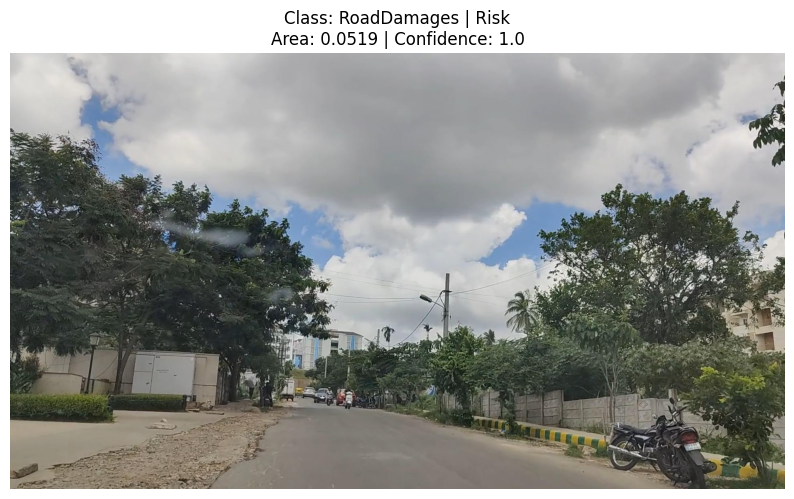

In [20]:
df = pd.read_csv('risk_damages_report.csv')
row = df.iloc[7]

img_path = splits['test'][0] / row['image_name']
img = Image.open(img_path)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"Class: RoadDamages | Risk\nArea: {row['damage_area_ratio']} | Confidence: {row['confidence']}")
plt.axis('off')
plt.show()